# Load required libraries

In [45]:
import pandas as pd
import numpy as np
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# Download the datasets from private S3 bucket

In [46]:
!aws s3 cp 's3://sagemaker-studio-111803057601-stq1w2z0tjr/df_psych.csv' ./data/

download: s3://sagemaker-studio-111803057601-stq1w2z0tjr/df_psych.csv to data/df_psych.csv


In [47]:
import csv

df_psych = pd.read_csv(
    "./data/df_psych.csv",
    delimiter=",",
    quoting=csv.QUOTE_NONE,
)
df_psych = df_psych.iloc[:,1:]
df_psych.head(100)

,user_id,platform_x,level_1,level_2,level_3,confidence_score,country_code,asset_id,minutes_viewed,showtype,genre,running_minutes,source_language,season_id,series_id,studio_id,minutes_under_2
0,8.589935e+10,web-embed,Psychographics,Movies Lovers,Horror Movies Fans,0.07,ID,10377,1,Movies,Horror,87,Indonesian,NaN,NaN,350.0,True
1,8.589935e+10,web-embed,Psychographics,Movies Lovers,Indonesian Movies Fans,0.03,ID,10377,1,Movies,Horror,87,Indonesian,NaN,NaN,350.0,True
2,2.576980e+10,android,Psychographics,Movies Lovers,Romance Movies Fans,0.52,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
3,2.576980e+10,android,Psychographics,TV Lovers,Kids TV Fans,0.61,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
4,2.576980e+10,android,Psychographics,TV Lovers,Drama TV Fans,0.60,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,7.700000e+01,android,Psychographics,Movies Lovers,Korean Movies Fans,0.54,ID,10377,12,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
96,7.700000e+01,android,Psychographics,Movies Lovers,English Movies Fans,0.46,ID,10377,12,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
97,7.700000e+01,android,Psychographics,TV Lovers,English TV Fans,0.40,ID,10377,12,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
98,6.871948e+10,android,Psychographics,TV Lovers,English TV Fans,0.29,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False


# Clean up missing values and outliers

## Missing values first

Recall that we have some missing values in the dataset

In [48]:
df_psych.isnull().sum()

user_id                  0
platform_x               0
level_1                  0
level_2                  0
level_3               4850
confidence_score         0
country_code             0
asset_id                 0
minutes_viewed           0
showtype                 0
genre                    5
running_minutes          0
source_language        701
season_id           146311
series_id           146311
studio_id              300
minutes_under_2          0
dtype: int64

It occurs to us that some records don't have genres so we remove those specific records.

In [49]:
df_psych = df_psych.dropna(subset=['genre'])
df_psych.isnull().sum()
print('\n')

We are going to see which studios are missing the source language.

In [50]:
df1 = df_psych[['studio_id','source_language']]
df2 = df1.loc[df1['source_language'].isna()]
print(df2['studio_id'].unique())

[229. 321.  10. 301.  79. 442. 373.  73. 127. 390.  69. 226. 170. 111.
 241. 447.]


In [51]:
df1[df1['studio_id'].isin([229., 321.,  10., 301.,  79., 442., 373.,  73., 127., 390.,  69.,
       226., 170., 111., 241., 447.])].groupby('studio_id')['source_language'].nunique()

studio_id
10.0     2
69.0     1
73.0     0
79.0     0
111.0    0
127.0    1
170.0    1
226.0    2
229.0    1
241.0    0
301.0    0
321.0    0
373.0    0
390.0    1
442.0    0
447.0    1
Name: source_language, dtype: int64

For the studios that are missing source language, there can be no language, one language or two languages. To avoid confusion, we will remove records with missing studio_id and source_language.

In [52]:
df_psych = df_psych.dropna(subset=['studio_id','source_language'])
df_psych.isnull().sum()

user_id                  0
platform_x               0
level_1                  0
level_2                  0
level_3               4839
confidence_score         0
country_code             0
asset_id                 0
minutes_viewed           0
showtype                 0
genre                    0
running_minutes          0
source_language          0
season_id           145653
series_id           145653
studio_id                0
minutes_under_2          0
dtype: int64

We can see that season_id and series_id have an equal amount of records and recall the showtype in the dataset has only 2 types.

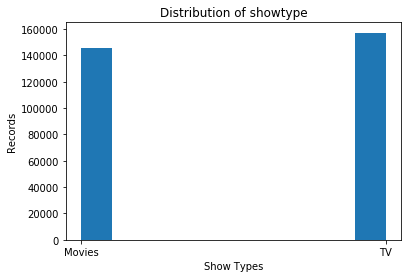

In [53]:
import matplotlib.pyplot as plt

plt.hist(df_psych['showtype'])
plt.xlabel("Show Types")
plt.ylabel("Records")
plt.title("Distribution of showtype")
plt.show()

In [54]:
df1 = df_psych[['showtype','season_id',"series_id"]]
df2 = df1.loc[(df1['season_id'].isna()) & (df1['series_id'].isna())]

In [55]:
df2.groupby('showtype')['season_id'].nunique()

showtype
Movies    1
Name: season_id, dtype: int64

In [56]:
df2.groupby('showtype')['series_id'].nunique()

showtype
Movies    1
Name: series_id, dtype: int64

This means that as long as we have valid season_id and series_id, the showtype must be TV shows while those values would be nulls for Movies.
Therefore, there is no need to keep season_id and series_id since they are directly correlated to showtype. So we remove the two columns.

In [57]:
df_psych = df_psych.drop(['season_id', 'series_id'], axis=1)
df_psych.isnull().sum()

user_id                0
platform_x             0
level_1                0
level_2                0
level_3             4839
confidence_score       0
country_code           0
asset_id               0
minutes_viewed         0
showtype               0
genre                  0
running_minutes        0
source_language        0
studio_id              0
minutes_under_2        0
dtype: int64

In [58]:
pd.unique(df_psych['level_3'])

array(['Horror Movies Fans', 'Indonesian Movies Fans',
       'Romance Movies Fans', 'Kids TV Fans', 'Drama TV Fans',
       'English TV Fans', 'Sports TV Fans', 'Malay TV Fans',
       'English Movies Fans', 'High Data Users',
       'Extreme Sports Movies Fans', 'Reality TV Fans', 'Comedy TV Fans',
       'Action and Adventure TV Fans', 'Comedy Movies Fans', nan,
       'Action and Adventure Movies Fans', 'Kids Movies Fans',
       'Local Commuters', 'Indonesian TV Fans', 'Thriller Movies Fans',
       'Korean TV Fans', 'Korean Movies Fans', 'Sci-Fi Movies Fans',
       'Drama Movies Fans', 'player', 'Malay Movies Fans',
       'Anime TV Fans', 'Fantasy Movies Fans', 'Family Movies Fans',
       '"""""""\\""""""""\\"""""""""""""""', 'Japanese TV Fans', 'casual',
       'Romance TV Fans', 'Japanese Movies Fans', 'Anime Movies Fans',
       'Chinese Movies Fans', 'Thai Movies Fans', 'Horror TV Fans',
       'Crime and Mystery Movies Fans', 'Hindi Movies Fans',
       'Turkish Movies Fa

Some level_3 traits are not valid, we will find out which level_2 traits those invalid level_3 traits belong to,
and replace the invalid level_3 traits to the same as level_2

In [59]:
pd.unique(df_psych['level_2'])

array(['Movies Lovers', 'TV Lovers', 'Mobile Enthusiasts',
       'News Junkies & Avid Readers', 'Travellers', 'Sports Fans',
       'iflix Viewing Behaviour', 'Social Media Fans', 'Music Lovers'],
      dtype=object)

In [60]:
lev3_null = df_psych.loc[df_psych['level_3'].isnull(), ('level_2')]
pd.unique(lev3_null)

array(['News Junkies & Avid Readers', 'Sports Fans', 'Music Lovers'],
      dtype=object)

In [61]:
# setting level_2 traits to be level_3 traits where level_3 is null.

df_psych.loc[df_psych['level_3'].isnull(),'level_3'] = df_psych['level_2']

df_psych.isnull().sum()


user_id             0
platform_x          0
level_1             0
level_2             0
level_3             0
confidence_score    0
country_code        0
asset_id            0
minutes_viewed      0
showtype            0
genre               0
running_minutes     0
source_language     0
studio_id           0
minutes_under_2     0
dtype: int64

In [62]:
pd.unique(df_psych['level_3'])

array(['Horror Movies Fans', 'Indonesian Movies Fans',
       'Romance Movies Fans', 'Kids TV Fans', 'Drama TV Fans',
       'English TV Fans', 'Sports TV Fans', 'Malay TV Fans',
       'English Movies Fans', 'High Data Users',
       'Extreme Sports Movies Fans', 'Reality TV Fans', 'Comedy TV Fans',
       'Action and Adventure TV Fans', 'Comedy Movies Fans',
       'News Junkies & Avid Readers', 'Action and Adventure Movies Fans',
       'Kids Movies Fans', 'Local Commuters', 'Indonesian TV Fans',
       'Thriller Movies Fans', 'Korean TV Fans', 'Korean Movies Fans',
       'Sports Fans', 'Sci-Fi Movies Fans', 'Drama Movies Fans', 'player',
       'Malay Movies Fans', 'Anime TV Fans', 'Fantasy Movies Fans',
       'Family Movies Fans', '"""""""\\""""""""\\"""""""""""""""',
       'Music Lovers', 'Japanese TV Fans', 'casual', 'Romance TV Fans',
       'Japanese Movies Fans', 'Anime Movies Fans', 'Chinese Movies Fans',
       'Thai Movies Fans', 'Horror TV Fans',
       'Crime and Myst

## Now consider outliers..

In [17]:
df_psych.describe()

,user_id,confidence_score,asset_id,minutes_viewed,running_minutes,studio_id
count,3.022100e+05,302210.000000,302210.000000,302210.000000,302210.000000,301910.000000
mean,4.798090e+10,0.626739,9453.082641,35.160713,72.759912,260.483826
std,2.993217e+10,0.317580,5083.836760,39.598786,33.644927,129.359736
min,1.000000e+00,0.000000,6.000000,0.000000,6.000000,3.000000
25%,2.576980e+10,0.330000,5263.000000,2.000000,47.000000,215.000000
50%,5.153961e+10,0.690000,9239.000000,19.000000,69.000000,265.000000
75%,7.730941e+10,0.930000,14309.000000,61.000000,97.000000,371.000000
max,9.448928e+10,1.000000,17269.000000,227.000000,173.000000,459.000000


Recall that we have plenty outilers in running_minutes and minutes_viewed

In [63]:
# Use a z-score of 3 as the cutoff

from scipy import stats


df_psych = df_psych[(np.abs(stats.zscore(df_psych['minutes_viewed']))< 3)]
df_psych = df_psych[(np.abs(stats.zscore(df_psych['running_minutes']))< 3)]

Text(0, 0.5, 'minutes_viewed')

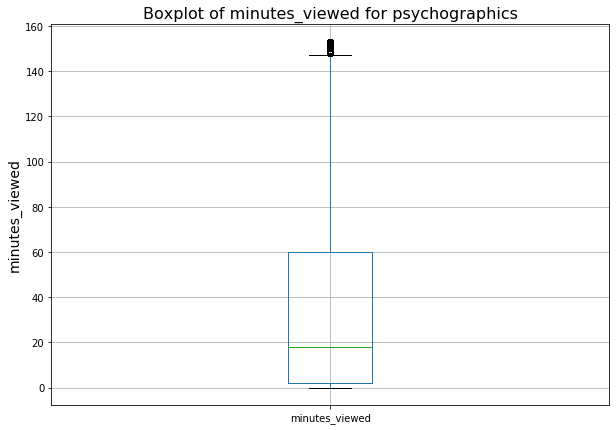

In [20]:
# Use boxplot to check for outliers in minutes_viewed
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))
boxplot = df_psych.boxplot(column=['minutes_viewed'])
plt.title("Boxplot of minutes_viewed for psychographics", fontsize = 16)
plt.ylabel("minutes_viewed", fontsize= 14 )

Text(0, 0.5, 'running_minutes')

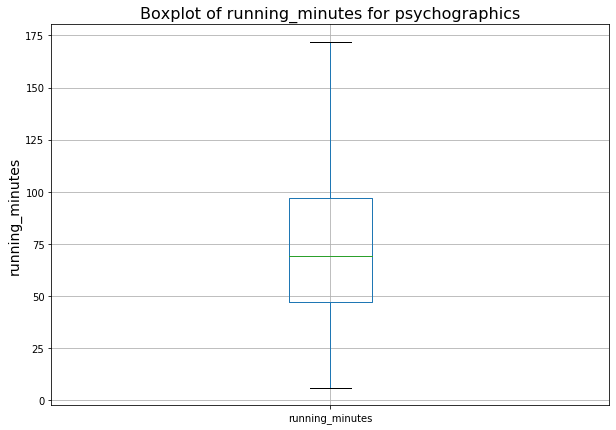

In [21]:
# Use boxplot to check for outliers in running_minutes

fig = plt.figure(figsize =(10, 7))
boxplot = df_psych.boxplot(column=['running_minutes'])
plt.title("Boxplot of running_minutes for psychographics", fontsize = 16)
plt.ylabel("running_minutes", fontsize= 14 )

# Feature Engineering

## Remove 'iflix Viewing Behaviour' from level_2 traits

In [64]:
df_psych[['level_2']].groupby('level_2').nunique()

,level_2
level_2,
Mobile Enthusiasts,1
Movies Lovers,1
Music Lovers,1
News Junkies & Avid Readers,1
Social Media Fans,1
Sports Fans,1
TV Lovers,1
Travellers,1
iflix Viewing Behaviour,1


Since "iflix Viewing Behaviour" doesn't fit into the rest of the traits, we will remove the records with it.

In [65]:
df_psych = df_psych[df_psych.level_2 != 'iflix Viewing Behaviour']
df_psych[['level_2']].groupby('level_2').nunique()

,level_2
level_2,
Mobile Enthusiasts,1
Movies Lovers,1
Music Lovers,1
News Junkies & Avid Readers,1
Social Media Fans,1
Sports Fans,1
TV Lovers,1
Travellers,1


## Feature Engineering

In [26]:
# viewing unique categories in these features - language, genre, and platform

pd.unique(df_psych['source_language'])

array(['Indonesian', 'English', 'Chinese', 'Malay', 'Nepali', 'Korean',
       'Tagalog', 'Japanese', 'Burmese', 'Kanuri', 'Thai', 'Hindi',
       'Tamil', 'Bengali', 'Vietnamese', 'Swahili', 'Central Khmer',
       'Portuguese', 'Urdu', 'Hungarian', 'Spanish; Castilian', 'French',
       'Italian', 'Turkish', 'Tajik', 'Swedish', 'Norwegian', 'Arabic',
       'Danish', 'Sinhala; Sinhalese', 'Afrikaans', 'Avaric'],
      dtype=object)

In [27]:
pd.unique(df_psych['genre'])

array(['Horror', 'Comedy', 'Drama', 'Thriller', 'Romance',
       'Action and Adventure', 'Others', 'Kids',
       'Documentary and Biography', 'Anime', 'Fantasy', 'Music',
       'Crime and Mystery', 'Sci-Fi', 'Reality', 'Sports',
       'Extreme Sports', 'Lifestyle and Fashion', 'Family', 'Game Show',
       'Best of Web or Viral', 'Animation', 'Education', 'eSports',
       'Adult Romance', 'News', 'Religion and Faith',
       'Health and Fitness', 'Live Events and Specials'], dtype=object)

In [66]:
pd.unique(df_psych['platform_x'])

array(['web-embed', 'android', 'iOS', 'android-tv', 'webOS', 'web',
       'Panasonic', 'web-pwa', 'Roku', 'Samsung Tizen', 'googlecast',
       'Vewd', 'Samsung Orsay'], dtype=object)

There's an opportunity to simplify the platform column

In [67]:
# Combine platforms into a more generalized group
# writing function platform_type

def platform_type (row):
    if row['platform_x'] in ('android','iOS'):
        return 'mobile_phone'
    if row['platform_x'] in ('web-embed', 'webOS', 'web', 'web-pwa'):
        return 'web_based'
    if row['platform_x'] in ('android-tv', 'Panasonic', 'Roku', 'Samsung Tizen', 'googlecast', 'Vewd', 'Samsung Orsay'):
        return 'home_tv'
    return row['platform_x']

In [68]:
# applying function to our dataframe, creating a new column 'platform_type' for this

df_psych['platform_type'] = df_psych.apply(lambda row: platform_type(row), axis=1)

In [69]:
# creating a feature for if an assett was watched for 2 (25th percentile) or more minutes

df_psych['viewed_2_plus'] = np.where(df_psych['minutes_viewed'] >= 2,1,0)

df_psych.head()

,user_id,platform_x,level_1,level_2,level_3,confidence_score,country_code,asset_id,minutes_viewed,showtype,genre,running_minutes,source_language,studio_id,minutes_under_2,platform_type,viewed_2_plus
0,8.589935e+10,web-embed,Psychographics,Movies Lovers,Horror Movies Fans,0.07,ID,10377,1,Movies,Horror,87,Indonesian,350.0,True,web_based,0
1,8.589935e+10,web-embed,Psychographics,Movies Lovers,Indonesian Movies Fans,0.03,ID,10377,1,Movies,Horror,87,Indonesian,350.0,True,web_based,0
2,2.576980e+10,android,Psychographics,Movies Lovers,Romance Movies Fans,0.52,ID,10377,3,Movies,Horror,87,Indonesian,350.0,False,mobile_phone,1
3,2.576980e+10,android,Psychographics,TV Lovers,Kids TV Fans,0.61,ID,10377,3,Movies,Horror,87,Indonesian,350.0,False,mobile_phone,1
4,2.576980e+10,android,Psychographics,TV Lovers,Drama TV Fans,0.60,ID,10377,3,Movies,Horror,87,Indonesian,350.0,False,mobile_phone,1


In [70]:
# creating a feature for if a viewing is over an hour long


df_psych['view_hour_plus'] = np.where(df_psych['minutes_viewed'] >= 60,1,0)


## Remove features that don't contribute to training models

In [71]:
df_psych = df_psych.drop(['user_id','level_1','level_3','asset_id','studio_id','minutes_under_2','platform_x'],axis = 1)
df_psych.head()

,level_2,confidence_score,country_code,minutes_viewed,showtype,genre,running_minutes,source_language,platform_type,viewed_2_plus,view_hour_plus
0,Movies Lovers,0.07,ID,1,Movies,Horror,87,Indonesian,web_based,0,0
1,Movies Lovers,0.03,ID,1,Movies,Horror,87,Indonesian,web_based,0,0
2,Movies Lovers,0.52,ID,3,Movies,Horror,87,Indonesian,mobile_phone,1,0
3,TV Lovers,0.61,ID,3,Movies,Horror,87,Indonesian,mobile_phone,1,0
4,TV Lovers,0.60,ID,3,Movies,Horror,87,Indonesian,mobile_phone,1,0


## Check Correlations between all independent variables

In [72]:
df = df_psych.drop(['level_2','confidence_score'],axis = 1)

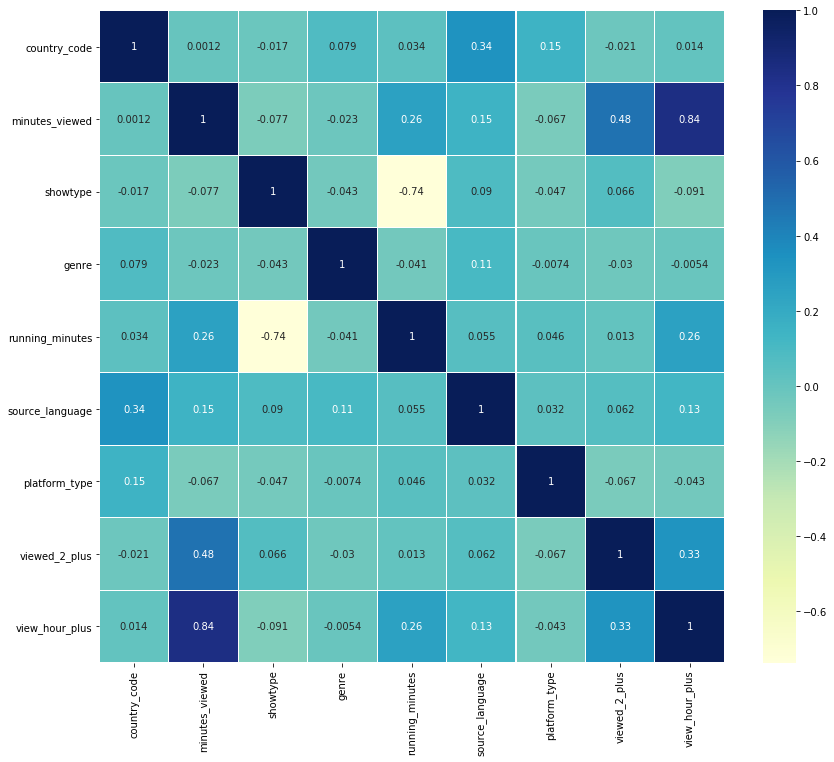

In [73]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])
    
    
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

Removing running_minutes from the dataframe due to high correlation with showtype, which we can recall from this:

In [75]:
sns.histplot(data=df_psych,x='running_minutes', hue = 'showtype', bins = 30)

AttributeError: module 'seaborn' has no attribute 'histplot'

running_minutes is almost directly related to the showtype.

In [76]:
df_psych = df_psych.drop(['running_minutes'],axis = 1)
df_psych.head()

,level_2,confidence_score,country_code,minutes_viewed,showtype,genre,source_language,platform_type,viewed_2_plus,view_hour_plus
0,Movies Lovers,0.07,ID,1,Movies,Horror,Indonesian,web_based,0,0
1,Movies Lovers,0.03,ID,1,Movies,Horror,Indonesian,web_based,0,0
2,Movies Lovers,0.52,ID,3,Movies,Horror,Indonesian,mobile_phone,1,0
3,TV Lovers,0.61,ID,3,Movies,Horror,Indonesian,mobile_phone,1,0
4,TV Lovers,0.60,ID,3,Movies,Horror,Indonesian,mobile_phone,1,0


Before balancing the data, we need to look at the confidence score from the original dataset:

In [77]:
df_psych['confidence_score'].describe()

count    279458.000000
mean          0.597657
std           0.311564
min           0.000000
25%           0.300000
50%           0.650000
75%           0.890000
max           1.000000
Name: confidence_score, dtype: float64

In [78]:
print('50th percentile: ', df_psych['confidence_score'].quantile(.5))
print('60th percentile: ', df_psych['confidence_score'].quantile(.6))
print('70th percentile: ', df_psych['confidence_score'].quantile(.7))
print('80th percentile: ', df_psych['confidence_score'].quantile(.8))
print('90th percentile: ', df_psych['confidence_score'].quantile(.9))
print('95th percentile: ', df_psych['confidence_score'].quantile(.95))

50th percentile:  0.65
60th percentile:  0.76
70th percentile:  0.86
80th percentile:  0.92
90th percentile:  0.98
95th percentile:  1.0


We want to ensure data quality and pick our record within 70th percentile

In [79]:
q7 = df_psych['confidence_score'].quantile(.7)

df_psych = df_psych.loc[df_psych['confidence_score'] > q7]
df_psych['confidence_score'].describe()

count    80385.000000
mean         0.949884
std          0.043058
min          0.870000
25%          0.910000
50%          0.960000
75%          0.990000
max          1.000000
Name: confidence_score, dtype: float64

We remove confidence_score from the dataset

In [80]:
df_psych = df_psych.drop(['confidence_score'], axis = 1)

## Encoding categorical data

In [81]:
df_psych.dtypes

level_2            object
country_code       object
minutes_viewed      int64
showtype           object
genre              object
source_language    object
platform_type      object
viewed_2_plus       int64
view_hour_plus      int64
dtype: object

In [82]:
# encoding showtype

df_psych = pd.get_dummies(df_psych,prefix=['showtype'], columns = ['showtype'], drop_first=True)

df_psych.head()

,level_2,country_code,minutes_viewed,genre,source_language,platform_type,viewed_2_plus,view_hour_plus,showtype_TV
26,Movies Lovers,ID,3,Horror,Indonesian,mobile_phone,1,0,0
37,Mobile Enthusiasts,ID,1,Horror,Indonesian,mobile_phone,0,0,0
40,Movies Lovers,ID,1,Horror,Indonesian,mobile_phone,0,0,0
44,Movies Lovers,ID,75,Horror,Indonesian,mobile_phone,1,1,0
45,Movies Lovers,ID,75,Horror,Indonesian,mobile_phone,1,1,0


In [83]:
# encoding genre
df_psych = pd.get_dummies(df_psych,prefix=['genre'], columns = ['genre'], drop_first=True)
df_psych.head()

,level_2,country_code,minutes_viewed,source_language,platform_type,viewed_2_plus,view_hour_plus,showtype_TV,genre_Adult Romance,genre_Animation,...,genre_Music,genre_News,genre_Others,genre_Reality,genre_Religion and Faith,genre_Romance,genre_Sci-Fi,genre_Sports,genre_Thriller,genre_eSports
26,Movies Lovers,ID,3,Indonesian,mobile_phone,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,Mobile Enthusiasts,ID,1,Indonesian,mobile_phone,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,Movies Lovers,ID,1,Indonesian,mobile_phone,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44,Movies Lovers,ID,75,Indonesian,mobile_phone,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,Movies Lovers,ID,75,Indonesian,mobile_phone,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
# encoding country_code
df_psych = pd.get_dummies(df_psych,prefix=['country_code'], columns = ['country_code'], drop_first=True)
df_psych.head()

,level_2,minutes_viewed,source_language,platform_type,viewed_2_plus,view_hour_plus,showtype_TV,genre_Adult Romance,genre_Animation,genre_Anime,...,country_code_LK,country_code_MM,country_code_MY,country_code_NP,country_code_PH,country_code_PK,country_code_SD,country_code_TH,country_code_VN,country_code_ZW
26,Movies Lovers,3,Indonesian,mobile_phone,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,Mobile Enthusiasts,1,Indonesian,mobile_phone,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,Movies Lovers,1,Indonesian,mobile_phone,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44,Movies Lovers,75,Indonesian,mobile_phone,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,Movies Lovers,75,Indonesian,mobile_phone,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
# encoding language
df_psych = pd.get_dummies(df_psych,prefix=['source_language'], columns = ['source_language'], drop_first=True)
df_psych.head()

,level_2,minutes_viewed,platform_type,viewed_2_plus,view_hour_plus,showtype_TV,genre_Adult Romance,genre_Animation,genre_Anime,genre_Comedy,...,source_language_Portuguese,source_language_Spanish; Castilian,source_language_Swahili,source_language_Tagalog,source_language_Tajik,source_language_Tamil,source_language_Thai,source_language_Turkish,source_language_Urdu,source_language_Vietnamese
26,Movies Lovers,3,mobile_phone,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,Mobile Enthusiasts,1,mobile_phone,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,Movies Lovers,1,mobile_phone,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44,Movies Lovers,75,mobile_phone,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,Movies Lovers,75,mobile_phone,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
# encoding platform_type
df_psych = pd.get_dummies(df_psych,prefix=['platform_type'], columns = ['platform_type'], drop_first=True)
df_psych.head()

,level_2,minutes_viewed,viewed_2_plus,view_hour_plus,showtype_TV,genre_Adult Romance,genre_Animation,genre_Anime,genre_Comedy,genre_Crime and Mystery,...,source_language_Swahili,source_language_Tagalog,source_language_Tajik,source_language_Tamil,source_language_Thai,source_language_Turkish,source_language_Urdu,source_language_Vietnamese,platform_type_mobile_phone,platform_type_web_based
26,Movies Lovers,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
37,Mobile Enthusiasts,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
40,Movies Lovers,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
44,Movies Lovers,75,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
45,Movies Lovers,75,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Balance The Data

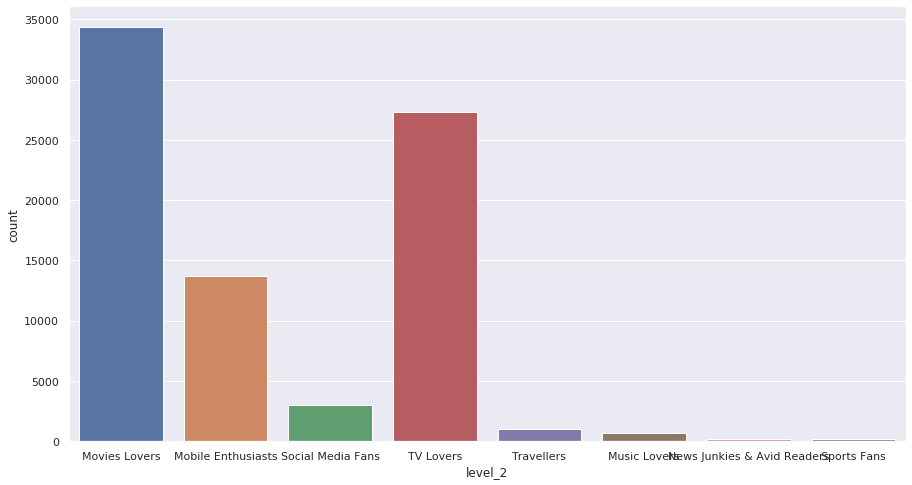

In [87]:
sns.set(rc={'figure.figsize':(15,8)})

sns.countplot(data=df_psych, x='level_2')

We can see that the target variable (level_2 trait) has a very uneven distribution the majority of its categories.

In [88]:
pd.set_option("display.max_rows", None)
df_psych['level_2'].value_counts()

Movies Lovers                  34345
TV Lovers                      27306
Mobile Enthusiasts             13712
Social Media Fans               3000
Travellers                       992
Music Lovers                     714
Sports Fans                      163
News Junkies & Avid Readers      153
Name: level_2, dtype: int64

Checking what the "baseline accuracy" would be for this model

In [89]:
baseline = (df_psych['level_2'].value_counts()[0] / df_psych.shape[0]) * 100

baseline

42.725632891708656

Movies Lovers is the number 1 category - roughly 41.89 % of the data is comprised of movie lovers, thus, the baseline accuracy of the model is 42.75%.

In [90]:
# going to balance data set using oversampling to ensure we have data for 

df_grouped_by = df_psych.groupby(["level_2"])
df_balanced = df_grouped_by.apply(
lambda x: x.sample(df_grouped_by.size().max(),replace=True)\
.reset_index(drop=True)
)

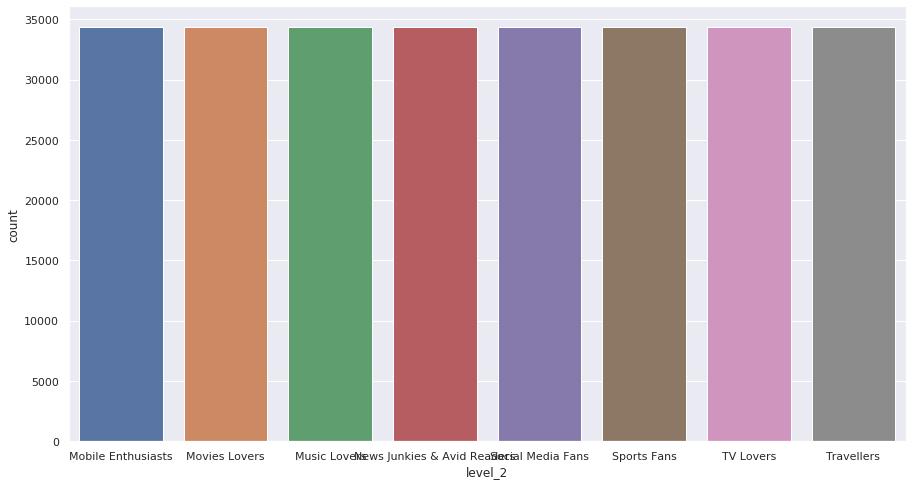

In [91]:
sns.set(rc={'figure.figsize':(15,8)})

sns.countplot(data=df_balanced, x='level_2')

In [71]:
df_balanced['level_2'].value_counts()

News Junkies & Avid Readers    34345
Mobile Enthusiasts             34345
Sports Fans                    34345
Music Lovers                   34345
TV Lovers                      34345
Travellers                     34345
Social Media Fans              34345
Movies Lovers                  34345
Name: level_2, dtype: int64

## Encoding the level_2 traits

In [94]:
df_balanced['level_2'] = df_balanced['level_2'].map({'Movies Lovers': 1, 'TV Lovers' : 2, 'Mobile Enthusiasts': 3, 'Social Media Fans': 4, 'Travellers': 5,
                    'Music Lovers': 6, 'News Junkies & Avid Readers':7, 'Sports Fans' : 8})

df_balanced.head()

level_2  minutes_viewed  viewed_2_plus  view_hour_plus  \
level_2                                                                        
Mobile Enthusiasts 0        3             110              1               1   
                   1        3               3              1               0   
                   2        3              26              1               0   
                   3        3              53              1               0   
                   4        3               2              1               0   

                      showtype_TV  genre_Adult Romance  genre_Animation  \
level_2                                                                   
Mobile Enthusiasts 0            0                    0                0   
                   1            1                    0                0   
                   2            1                    0                0   
                   3            1                    0                0   
                   4            0                    0                0   

                      genre_Anime  genre_Comedy  genre_Crime and Mystery  ...  \
level_2                                                                   ...   
Mobile Enthusiasts 0            0             0                        0  ...   
                   1            0             0                        0  ...   
                   2            0             0                        0  ...   
                   3            0             0                        0  ...   
                   4            0             0                        0  ...   

                      source_language_Swahili  source_language_Tagalog  \
level_2                                                                  
Mobile Enthusiasts 0                        0                        0   
                   1                        0                        0   
                   2                        0                        0   
                   3                        0                        0   
                   4                        0                        0   

                      source_language_Tajik  source_language_Tamil  \
level_2                                                              
Mobile Enthusiasts 0                      0                      0   
                   1                      0                      0   
                   2                      0                      0   
                   3                      0                      0   
                   4                      0                      0   

                      source_language_Thai  source_language_Turkish  \
level_2                                                               
Mobile Enthusiasts 0                     0                        0   
                   1                     0                        0   
                   2                     0                        0   
                   3                     0                        0   
                   4                     0                        0   

                      source_language_Urdu  source_language_Vietnamese  \
level_2                                                                  
Mobile Enthusiasts 0                     0                           0   
                   1                     0                           0   
                   2                     0                           0   
                   3                     0                           0   
                   4                     0                           0   

                      platform_type_mobile_phone  platform_type_web_based  
level_2                                                                    
Mobile Enthusiasts 0                           1                        0  
                   1                           1                        0  
                   2                

# Split the data into train, validate and test

In [95]:
# Split the data as: train - 90%, validate - 5%, test - 5%

from sklearn.model_selection import train_test_split

# Split all data into 70% train and 30% holdout
df_train, df_holdout = train_test_split(df_balanced, test_size=0.10, stratify=df_balanced['level_2'])

# Split holdout data into 50% validation and 50% test
df_validation, df_test = train_test_split(df_holdout, test_size=0.50, stratify=df_holdout['level_2'])

In [96]:
df_train.shape

(247284, 79)

In [97]:
df_train.head()

,,level_2,minutes_viewed,viewed_2_plus,view_hour_plus,showtype_TV,genre_Adult Romance,genre_Animation,genre_Anime,genre_Comedy,genre_Crime and Mystery,...,source_language_Swahili,source_language_Tagalog,source_language_Tajik,source_language_Tamil,source_language_Thai,source_language_Turkish,source_language_Urdu,source_language_Vietnamese,platform_type_mobile_phone,platform_type_web_based
level_2,,,,,,,,,,,,,,,,,,,,,,
News Junkies & Avid Readers,13517,7,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
TV Lovers,1507,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Music Lovers,26987,6,21,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
TV Lovers,24114,2,64,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Music Lovers,21684,6,26,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [98]:
df_validation.shape

df_validation.head()

,,level_2,minutes_viewed,viewed_2_plus,view_hour_plus,showtype_TV,genre_Adult Romance,genre_Animation,genre_Anime,genre_Comedy,genre_Crime and Mystery,...,source_language_Swahili,source_language_Tagalog,source_language_Tajik,source_language_Tamil,source_language_Thai,source_language_Turkish,source_language_Urdu,source_language_Vietnamese,platform_type_mobile_phone,platform_type_web_based
level_2,,,,,,,,,,,,,,,,,,,,,,
Mobile Enthusiasts,32151,3,60,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
TV Lovers,16218,2,30,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
Movies Lovers,7401,1,7,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Social Media Fans,29783,4,5,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Movies Lovers,1127,1,2,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [99]:
df_test.shape

(13738, 79)

In [100]:
df_train = df_train.drop('level_2', axis=1)

df_train.head()

,,minutes_viewed,viewed_2_plus,view_hour_plus,showtype_TV,genre_Adult Romance,genre_Animation,genre_Anime,genre_Comedy,genre_Crime and Mystery,genre_Documentary and Biography,...,source_language_Swahili,source_language_Tagalog,source_language_Tajik,source_language_Tamil,source_language_Thai,source_language_Turkish,source_language_Urdu,source_language_Vietnamese,platform_type_mobile_phone,platform_type_web_based
level_2,,,,,,,,,,,,,,,,,,,,,,
News Junkies & Avid Readers,13517,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
TV Lovers,1507,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Music Lovers,26987,21,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
TV Lovers,24114,64,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Music Lovers,21684,26,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [101]:
df_train.index.value_counts

<bound method IndexOpsMixin.value_counts of MultiIndex([('News Junkies & Avid Readers', 13517),
            (                  'TV Lovers',  1507),
            (               'Music Lovers', 26987),
            (                  'TV Lovers', 24114),
            (               'Music Lovers', 21684),
            (          'Social Media Fans',  5683),
            (               'Music Lovers', 26157),
            (          'Social Media Fans', 32702),
            (         'Mobile Enthusiasts', 24722),
            ('News Junkies & Avid Readers',  5889),
            ...
            (              'Movies Lovers', 12407),
            (         'Mobile Enthusiasts',  5133),
            (                'Sports Fans', 11638),
            (         'Mobile Enthusiasts',  6854),
            (               'Music Lovers', 15396),
            (                 'Travellers', 11560),
            (               'Music Lovers',  4481),
            (          'Social Media Fans', 22265),
    

# Save these files to S3 bucket

In [102]:
# Create a new s3 bucket
!aws s3 mb s3://ads508-team4-split

make_bucket failed: s3://ads508-team4-split An error occurred (BucketAlreadyExists) when calling the CreateBucket operation: The requested bucket name is not available. The bucket namespace is shared by all users of the system. Please select a different name and try again.


In [104]:
# Store these 3 files

from io import StringIO

bucket = 'ads508-kuc2'
csv_buffer1 = StringIO()
csv_buffer2 = StringIO()
csv_buffer3 = StringIO()

df_train.to_csv(csv_buffer1)
df_validation.to_csv(csv_buffer2)
df_test.to_csv(csv_buffer3)

s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'df_train.csv').put(Body=csv_buffer1.getvalue())
s3_resource.Object(bucket, 'df_validation.csv').put(Body=csv_buffer2.getvalue())
s3_resource.Object(bucket, 'df_test.csv').put(Body=csv_buffer3.getvalue())

{'ResponseMetadata': {'RequestId': 'ZQSVJX98E4K5KBW2',
  'HostId': 'XAMAm5Jw1K5ylKT+dLmCXSsmSEvQCoj2OhhCILraeI685gUpGpegdk827qG5AQV67yOgtKHtN8o=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'XAMAm5Jw1K5ylKT+dLmCXSsmSEvQCoj2OhhCILraeI685gUpGpegdk827qG5AQV67yOgtKHtN8o=',
   'x-amz-request-id': 'ZQSVJX98E4K5KBW2',
   'date': 'Wed, 30 Mar 2022 03:22:27 GMT',
   'etag': '"b2d9f605860669956722f128bfb4c4a3"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"b2d9f605860669956722f128bfb4c4a3"'}

In [105]:
df_train.head()

,,minutes_viewed,viewed_2_plus,view_hour_plus,showtype_TV,genre_Adult Romance,genre_Animation,genre_Anime,genre_Comedy,genre_Crime and Mystery,genre_Documentary and Biography,...,source_language_Swahili,source_language_Tagalog,source_language_Tajik,source_language_Tamil,source_language_Thai,source_language_Turkish,source_language_Urdu,source_language_Vietnamese,platform_type_mobile_phone,platform_type_web_based
level_2,,,,,,,,,,,,,,,,,,,,,,
News Junkies & Avid Readers,13517,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
TV Lovers,1507,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Music Lovers,26987,21,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
TV Lovers,24114,64,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Music Lovers,21684,26,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
